# 04. PyTorch Custom Datasets Video Notebook

Usamos alguns datasets com PyTorch anteriormente. Mas como podemos usar nossos próprios datasets?

## Bibliotecas do domínio

Dependendo do que estamos trabalhando, visão ,texto, audio, recomendação, você irá querer encontrar a biblioteca recomendada do PyTorch.

Recurso: https://www.learnpytorch.io/04_pytorch_custom_datasets/

# 0. Importando bibliotecas e definindo código agnóstico a dispositivo


In [1]:
import torch
from torch import nn

# Nota: PyTorch 1.10.0 + é necessário
torch.__version__

'1.13.1+cu116'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
!nvidia-smi

Wed Feb 22 21:14:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    30W /  70W |      3MiB / 15360MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. Conseguindo dados

O nosso dataset é um subconjunto do dataset [Food101](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/). O Food101 possui 101 classes diferentes de comidas, 100 imagens por classe (750 para treino e 250 para teste).

Nosso subconjunto possui 3 classes e apenas 10% das imagens.

Estamos fazendo isso para apenas testar experimentos em uma escala menor e, então, aumentar a escala quando necessário.

O objetivo é aumentar a velocidade de experimentação.

In [4]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# Se a pasta de imagens não existir, download dela

if image_path.is_dir():
  print(f"{image_path} diretório já existe... pulando download")
else:
  print(f"{image_path} não existe, criando um...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download

with open(data_path / "pizza_steak_sushi.zip", 'wb') as f:
  data_url = 'https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip'
  request = requests.get(data_url)
  print("Baixando os dados...")
  f.write(request.content)

# Unzip
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", 'r') as zip_ref:
  print("Extraindo dados...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi não existe, criando um...
Baixando os dados...
Extraindo dados...


## 2. Se tornando um com os dados (Preparação e exploração dos dados)

In [5]:
import os
def walk_through_dir(dir_path):
  """
  Anda pelo dir_path retornando seus conteúdos
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"Existem {len(dirnames)} diretórios e {len(filenames)} imagens em '{dirpath}'")

In [6]:
walk_through_dir(image_path)

Existem 2 diretórios e 0 imagens em 'data/pizza_steak_sushi'
Existem 3 diretórios e 0 imagens em 'data/pizza_steak_sushi/train'
Existem 0 diretórios e 78 imagens em 'data/pizza_steak_sushi/train/pizza'
Existem 0 diretórios e 72 imagens em 'data/pizza_steak_sushi/train/sushi'
Existem 0 diretórios e 75 imagens em 'data/pizza_steak_sushi/train/steak'
Existem 3 diretórios e 0 imagens em 'data/pizza_steak_sushi/test'
Existem 0 diretórios e 25 imagens em 'data/pizza_steak_sushi/test/pizza'
Existem 0 diretórios e 31 imagens em 'data/pizza_steak_sushi/test/sushi'
Existem 0 diretórios e 19 imagens em 'data/pizza_steak_sushi/test/steak'


In [7]:
# Configurando caminhos de treino e de teste
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2.1 Visualizando uma imagem

Vamos escrever código para:
1. Conseguir todos os caminhos das imagens
2. Escolher um caminho aleatório usando `random.choice()`
3. Conseguir a classe da imagem usando `pathlib.Path.parent.stem`
4. Já que estamos trabalhando com imagens, vamos ver as imagens com PIL (Pillow)
5. Mostrar a imagem e metadados

Random image path: data/pizza_steak_sushi/train/pizza/3281494.jpg
Image class: pizza
Altura Imagem: 288
Largura Imagem: 512


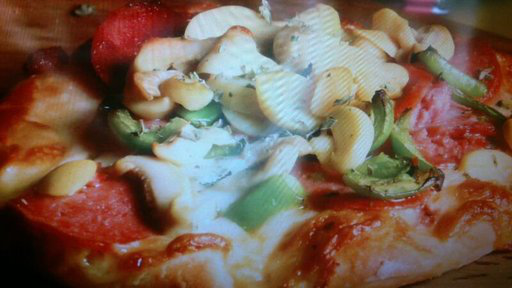

In [8]:
import random
from PIL import Image

random.seed(42)

# 1.
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2.
random_image_path = random.choice(image_path_list)

# 3. 
image_class = random_image_path.parent.stem

# 4.
img = Image.open(random_image_path)

# 5.
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Altura Imagem: {img.height}")
print(f"Largura Imagem: {img.width}")

img

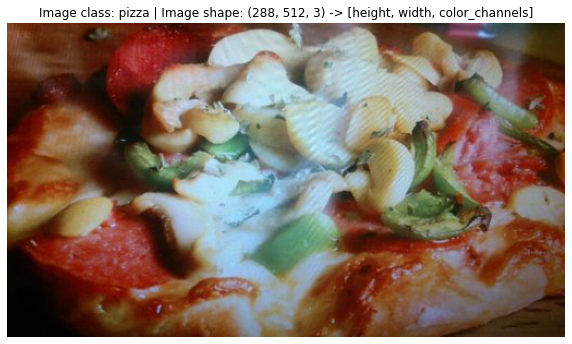

In [9]:
# Plotando com matplotlib

import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

# 3. Transformando os dados

Antes de podermos usar os dados com PyTorch:
1. Transformar os dados em tensores
2. Transformar os dados em `torch.utils.data.Dataset` e, então, `torch.utils.data.DataLoader`

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## 3.1 Transformando os dados com `torchvisions.transforms`

Recurso: https://pytorch.org/vision/stable/transforms.html

In [11]:
## também poderíamos usar nn.Sequential
data_transform = transforms.Compose([
    # Muda o shape das imagens
    transforms.Resize(size=(64, 64)),
    # Vira as imagens horizontalmente de forma aleatória
    # para data augmentation com prob de 50%
    transforms.RandomHorizontalFlip(p=0.5),
    # Torna em um torch.tensor
    transforms.ToTensor()
])

In [12]:
data_transform(img).shape

torch.Size([3, 64, 64])

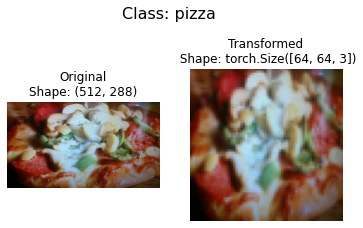

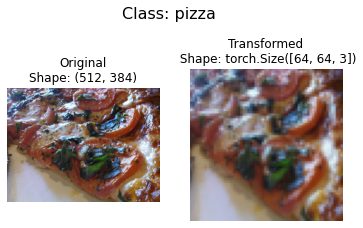

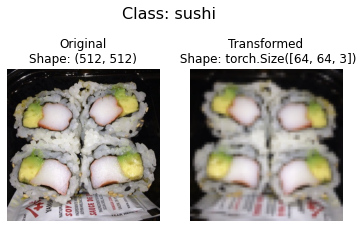

In [13]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Seleciona imagens aleatórias do caminho de imagens e carrega/transforma
  e plota a original vs a transformada
  """
  if seed:
    random.seed(seed)
    torch.manual_seed(42)
  
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nShape: {f.size}")
      ax[0].axis(False)

      # o matplotlib quer (C, H, W) -> (H, W, C)
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\n Shape: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list, 
                        transform = data_transform,
                        n=3,
                        seed=42)

# 4. Opção 1: Carregando dados usando `ImageFolder`

Podemos carregar dados de classificação usando `torchvision.datasets.ImageFolder`

Recurso: https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder

In [14]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # dados
                                  target_transform=None) # target/label
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
len(train_data), len(test_data)

(225, 75)

In [18]:
# Conseguindo uma imagem e seu label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [color channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [heigth, width, color_channels]


Text(0.5, 1.0, 'pizza')

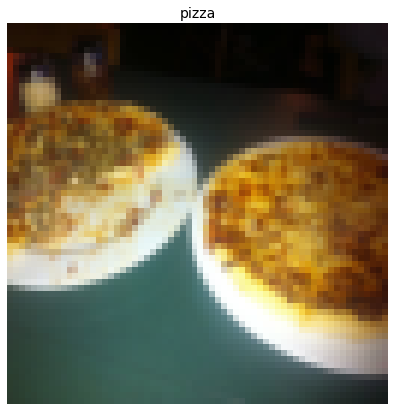

In [19]:
# Reordenando a ordem das dimensões
img_permute = img.permute(1, 2, 0)

print(f"Original shape: {img.shape} -> [color channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [heigth, width, color_channels]")

plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14)

## 4.1 Torna imagens carregadas em `DataLoader`'s

Um `DataLoader` nos ajudará a tornar o nosso `Dataset` em iteráveis e poderemos alterar o `batch_size` para que o nosso modelo veja `batch_size` por vez.

In [20]:
!nvidia-smi

Wed Feb 22 21:14:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    30W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 16

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f3a40bc1eb0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f3a40bd4760>)

In [22]:
# Qt of batches per dataloader
len(train_dataloader), len(test_dataloader)

(15, 5)

In [23]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, c_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([16, 3, 64, 64]) -> [batch_size, c_channels, height, width]
Label shape: torch.Size([16])


# 5. Opção 2: Carregando imagens com uma class `Dataset` Customizada

1. Queremos conseguir carregar imagens de um arquivo
2. Queremos conseguir os nomes das classes do Dataset
3. Queremos conseguir os nomes das classes no formato dicionário

Pros:
* Podemos criar um `Dataset` a partir de quase tudo
* Não está limitado às funções padrão do `Dataset` do PyTorch

Contras:
* Apesar de poder criar um `Dataset` para quase tudo, ele não significa que vai funcionar
* Usar um `Dataset` próprio geralmente resulta em mais código, que pode estar passível a erros ou problemas de performance

Todos os datasets customizados em PyTorch geralmente herdam de https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

In [24]:
import os
import pathlib
import torchvision

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [25]:
# Instância de torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## 5.1 Criando uma função auxiliar para pegar os nomes das classes

Queremos uma função para
1. Conseguir os nomes das classes usando `os.scandir()` para passar por um diretório alvo (idealmente o diretório está no formato padrão de classificação de imagens).
2. Levantar uma exceção se os nomes das classes não forem encontrados (se isso acontecer, pode ter algo errado com a estrutura de diretórios
3. Torna os nomes das classes em dicionários e uma lista e os retorna.

In [26]:
# Configurar o caminho do diretório alvo
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Consegue os nomes das classes do diretório alvo
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [27]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """
  Encontra os nomes das classes no diretório alvo.
  """
  # 1.
  classes = sorted([entry.name for entry in os.scandir(directory) if entry.is_dir()])
  
  if not classes:
    raise FileNotFoundError(f"Não foi possível encontrar classes no diretório")

  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [28]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## 5.2 Criando um `Dataset` customizado para replicar `ImageFolder`

Para criar nosso próprio Dataset, queremos:

1. Herdar de `torch.utils.data.Dataset`
2. Inicializar a subclasses com um diretório alvo e um transform se quisermos transformar os dados
3. Criar muitos atributos
  * path - caminho das imagens
  * transform - O transformador que queremos usar
  * classes - uma lista de classes alvo
  * class_to_idx - Um dicionário de classes alvo mapeado para inteiros
4. Criar uma função `load_images()` que carrega imagens
5. Sobrescrever o método `__len()__` para retornar o tamanho do dataset de acordo com a documentação
6. Sobrescrever o método `__getitem()__` para retornar uma dada amostra de acordo com a documentação

In [29]:
from torch.utils.data import Dataset
# 1
class ImageFolderCustom(Dataset):
  # 2
  def __init__(self, targ_dir: str, transform=None):
    """
    Espera que o diretório do dataset esteja no padrão targ_dir/class/image.jpg
    """
    # 3
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    self.transform = transform
    self.classes, self.class_to_idx = self._find_classes(targ_dir)
  
  def _find_classes(self, directory: str) -> Tuple[List[str], Dict[str, int]]:
    """
    Encontra os nomes das classes no diretório alvo.
    """
    classes = sorted([entry.name for entry in os.scandir(directory) if entry.is_dir()])
    
    if not classes:
      raise FileNotFoundError(f"Não foi possível encontrar classes no diretório")

    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

  # 4
  def load_image(self, index: int) -> Image.Image:
    "Abre uma imagem via um path e o retorna"
    image_path = self.paths[index]
    return Image.open(image_path)
  
  # 5
  def __len__(self) -> int:
    "Retorna a quantidade total de amostras"
    return len(self.paths)
  
  # 6
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Retorna uma mostra dos dados, dado e label (X, y)"
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [30]:
# Criando um transform
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [31]:
# Testando ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transform=test_transforms)

In [32]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7f3a40b6c790>,
 <__main__.ImageFolderCustom at 0x7f3a40b6c700>)

In [33]:
len(train_data), len(train_data_custom)

(225, 225)

In [34]:
len(test_data), len(test_data_custom)

(75, 75)

In [35]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [36]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [37]:
# Checando por equalidade entre dataset do ImageFolder original
# e o ImageFolderCustom

print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


## 5.3 Criando uma função para mostrar imagens aleatórias

1. Receber um `Dataset` e outros parâmetros como nomes das classes e quantas imagens mostrar
2. Para prevenir que não saia nada estranho, vamos limitar a quantidade de imagens em 10.
3. Definir o random seed para reproducibilidade
4. Conseguir uma lista de indexes aleatórios do dataset alvo.
5. Configurar um plot matplotlib
6. Loop pelos indexes e plotar imagens
7. Ter certeza que as dimensões das imagens estejam de acordo com o matplotlib (HWC)

In [38]:
# 1
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2
  if n > 10:
    n = 10
    display_shape = False
    print(f"Por motivos de display, n não deve ser maior do que 10. Definindo n = 10")

  # 3
  if seed:
    random.seed(seed)
  
  # 4
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # 5
  plt.figure(figsize=(16, 8))

  # 6
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7
    targ_image_adjust = targ_image.permute(1, 2, 0)

    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis(False)
    title = ""
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nShape: {targ_image_adjust.shape}"

    plt.title(title)



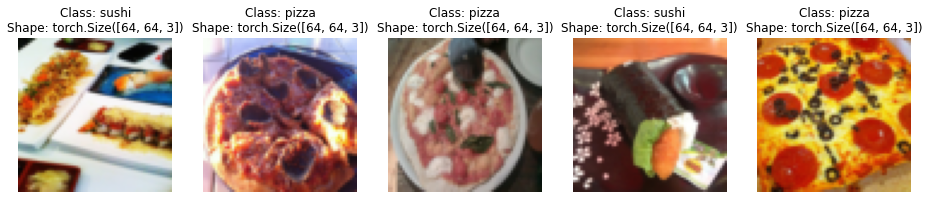

In [39]:
display_random_images(train_data, n=5, classes=class_names, seed=42)

Por motivos de display, n não deve ser maior do que 10. Definindo n = 10


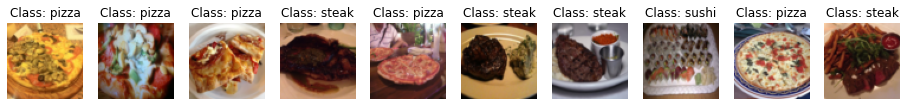

In [40]:
display_random_images(train_data_custom, n=20, classes=class_names, seed=None)

## 5.4 Torna imagens carregadas de forma personalizada em `DataLoader`'s

In [41]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f3a27681a00>,
 <torch.utils.data.dataloader.DataLoader at 0x7f3a276815b0>)

In [42]:
img_custom, label_custom = next(iter(train_dataloader_custom))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

# 6. Data Augmentation

Data augmentation é o processo de artificialmente adicionar diversidade aos dados de treino.

No caso de dados de imagem, isso pode significar aplicar várias transformações às imagens de treino

Essa prática resulta em um modelo que generaliza melhor

Vamos ver um tipo em particular de data augmentation usado para treinar modelos de visão PyTorch em um nível estado da arte

Recurso: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/



In [43]:
# Vamos ver o TrivialAugment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # Define qual a intensidade das transformações
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [44]:
train_transform, test_transform

(Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
     TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
     ToTensor()
 ), Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
     ToTensor()
 ))

In [45]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/pizza/3530210.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/1033251.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/3589437.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/3505182.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/3109486.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/702165.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/12301.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/618348.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2190018.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2026009.jpg')]

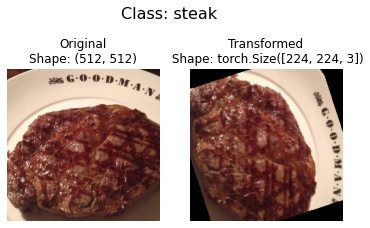

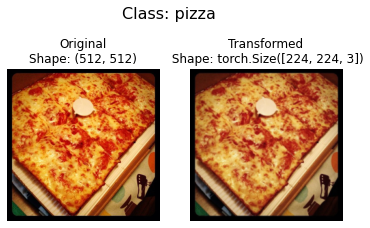

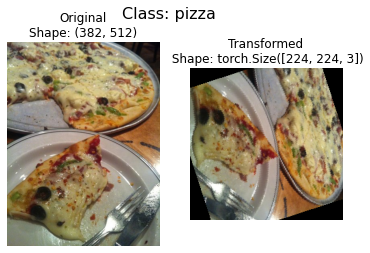

In [46]:
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

# 7. Model 0: TinyVGG sem data augmentation

Vamos replicar a arquitetura TinyVGG do site CNN Explainer

Recurso: https://poloclub.github.io/cnn-explainer/

## 7.1 Criando transforms e carregando dados para o Model 0

In [47]:
# Criando um transform simples
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [48]:
from torchvision.datasets import ImageFolder
train_data_simple = ImageFolder(root=train_dir,
                         transform=simple_transform, 
                         target_transform=None)

test_data_simple = ImageFolder(root=test_dir,
                        transform=simple_transform,
                        target_transform=None)

In [49]:
from torch.utils.data import DataLoader
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_simple = torch.utils.data.DataLoader(
    dataset=train_data_simple, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=NUM_WORKERS
)

test_dataloader_simple = torch.utils.data.DataLoader(
    dataset=test_data_simple, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=NUM_WORKERS
)

## 7.2 Construindo a classe do modelo TinyVGG

In [50]:
from torch import nn
class TinyVGG(nn.Module):
  """
  Arquitetura copiada do CNN Explainer
  """
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
      super().__init__()
      self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                       stride=2)
      )
      self.conv_block_2 = nn.Sequential(
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                       stride=2)
      )
      self.classifier = nn.Sequential(nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
        out_features=output_shape)
      )
    
  
  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    # Poderíamos fazer:
    # return self.classifier(self.conv_block_2(self.conv_block_1(x)))
    # que seria mais rápido
    return x

In [51]:
torch.manual_seed(42)
model_0 = TinyVGG(
    input_shape=3, #Número de canais nas imagens
    hidden_units=10,
    output_shape=len(class_names)
).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

## 7.3 Realizando uma forward pass para testar o modelo

In [52]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [53]:
model_0.eval()
with torch.inference_mode():
  model_0(image_batch.to(device))

O erro acima está dizendo que, como as hidden_units é igual a 10 e o valor de entrada possui 1690, teremos que alterar o in_features do classifier. No caso, sqrt(1690/10) = 13, logo, se alterarmos para hidden_units\*13\*13 dará certo

In [54]:
model_0.eval()
with torch.inference_mode():
  model_0(image_batch.to(device))

## 7.4 Usando `torchinfo` para inspecionar o modelo

In [55]:
# Instalando torchinfo
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # [batch, color_c, width, height]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## 7.5 Criando funções de treino e teste

* `train_step()` - Recebe um modelo e um dataloader e treina o modelo no dataloader
* `test_step()` - Recebe um modelo e um dataloader e avalia o modelo no dataloader

In [56]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer,
               loss_fn: torch.nn.Module,
               device: str = "cpu"):
  
  model.to(device)
  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)
  
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

In [57]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: str = 'cpu'):
  
  model.to(device)
  model.eval()

  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      y_pred_logits = model(X)
      
      loss = loss_fn(y_pred_logits, y)
      test_loss += loss.item()

      test_pred_labels = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
      test_acc += (test_pred_labels==y).sum().item()/len(y)
    
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
  return test_loss, test_acc

## 7.6 Criando uma função `train()`

In [58]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device: str = 'cpu'):
  
  results = {"train_loss":[],
             "train_acc":[],
             "test_loss":[],
             "test_acc":[]}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader= train_dataloader,
                                       optimizer=optimizer,
                                       loss_fn=loss_fn,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                       dataloader= test_dataloader,
                                       loss_fn=loss_fn,
                                       device=device)
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f}, Test_acc: {test_acc:.4f}")
    results['train_loss'].append(train_loss)
    results['test_loss'].append(test_loss)
    results['train_acc'].append(train_acc)
    results['test_acc'].append(test_acc)
  
  return results

## 7.7 Treinando e avaliando o modelo 0

In [59]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)
from timeit import default_timer as timer
start_time = timer()
model_0_results = train(model=model_0,
      train_dataloader=train_dataloader_simple,
      test_dataloader=test_dataloader_simple,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=NUM_EPOCHS,
      device=device)

end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1063, Train acc: 0.3047 | Test loss: 1.0983, Test_acc: 0.3116
Epoch: 1 | Train loss: 1.0995, Train acc: 0.3320 | Test loss: 1.0699, Test_acc: 0.5417
Epoch: 2 | Train loss: 1.0863, Train acc: 0.4922 | Test loss: 1.0800, Test_acc: 0.5227
Epoch: 3 | Train loss: 1.0826, Train acc: 0.4102 | Test loss: 1.0599, Test_acc: 0.5729
Epoch: 4 | Train loss: 1.0630, Train acc: 0.4141 | Test loss: 1.0609, Test_acc: 0.5540
Total training time: 13.496 seconds


O modelo não está indo tão bem com 0.55 de acurácia no teste.

## 7.8 Plotando as curvas de loss do modelo 0

Uma curva de loss é uma maneira de rastrear o progresso do modelo ao longo do tempo.

Recurso: https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic?hl=pt-br

In [60]:
def plot_loss_curves(results: Dict[str, List[float]]):
  train_loss = results['train_loss']
  test_loss = results['test_loss']
  train_acc = results['train_acc']
  test_acc = results['test_acc']
  epochs = range(len(train_loss))

  plt.figure(figsize=(15, 7))
  
  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.ylabel("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_acc, label="train_acc")
  plt.plot(epochs, test_acc, label="test_acc")
  plt.title("Accuracy")
  plt.ylabel("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()
  plt.show()

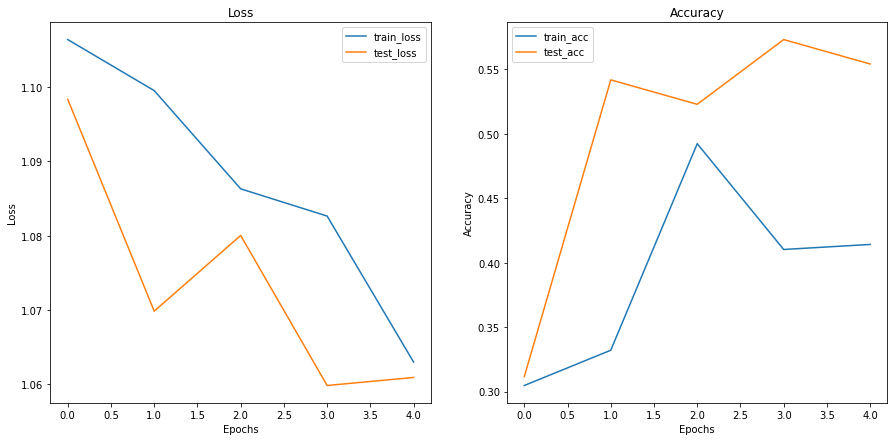

In [61]:
plot_loss_curves(model_0_results)

# 8. Como uma curva loss ideal deve ser?

https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic?hl=pt-br

Uma curva loss é uma das melhores formas para entender um modelo.

# 9 Model 1: TinyVGG com DataAugmentation

Vamos tentar outro experimento de modelagem. Desta vez, usando o mesmo modelo que antes mas com *data augmentation*

## 9.1 Criando transform com data augmentation

In [63]:
from torchvision import transforms
train_transform_trivial = transforms.Compose(
    [
        transforms.Resize(size=(64, 64)),
        transforms.TrivialAugmentWide(num_magnitude_bins=31),
        transforms.ToTensor()
    ]
)


# Não precisamos realizar data augmentation no dataset de teste
test_transform_simple = transforms.Compose(
    [
        transforms.Resize(size=(64, 64)),
        transforms.ToTensor()
    ]
)

## 9.2 Criando `Dataset` e `DataLoader` de treino e teste com data augmentation

In [64]:
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(
    root=train_dir,
    transform=train_transform_trivial
)

test_data_simple = datasets.ImageFolder(
    root=test_dir,
    transform=test_transform_simple
)

In [65]:
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
torch.manual_seed(42)

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False,
                                        num_workers=NUM_WORKERS)

## 9.3 Construindo e treinando o modelo 1

Usaremos o mesmo modelo que já utilizamos, entretanto, agora usamos de data augmentation nos dados de treino.

In [67]:
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [68]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

from timeit import default_timer as timer
start_time = timer()
model_1_results = train(model=model_1,
      train_dataloader=train_dataloader_augmented,
      test_dataloader=test_dataloader_simple,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=NUM_EPOCHS,
      device=device)

end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1049, Train acc: 0.2500 | Test loss: 1.1019, Test_acc: 0.2604
Epoch: 1 | Train loss: 1.0807, Train acc: 0.4258 | Test loss: 1.1260, Test_acc: 0.2604
Epoch: 2 | Train loss: 1.0714, Train acc: 0.4258 | Test loss: 1.1585, Test_acc: 0.2604
Epoch: 3 | Train loss: 1.1251, Train acc: 0.3047 | Test loss: 1.1586, Test_acc: 0.2604
Epoch: 4 | Train loss: 1.0849, Train acc: 0.4219 | Test loss: 1.1551, Test_acc: 0.3229
Total training time: 8.764 seconds


## 9.4 Plotando e avaliando o modelo 1

Parece que a sua performance foi pior do que a do primeiro

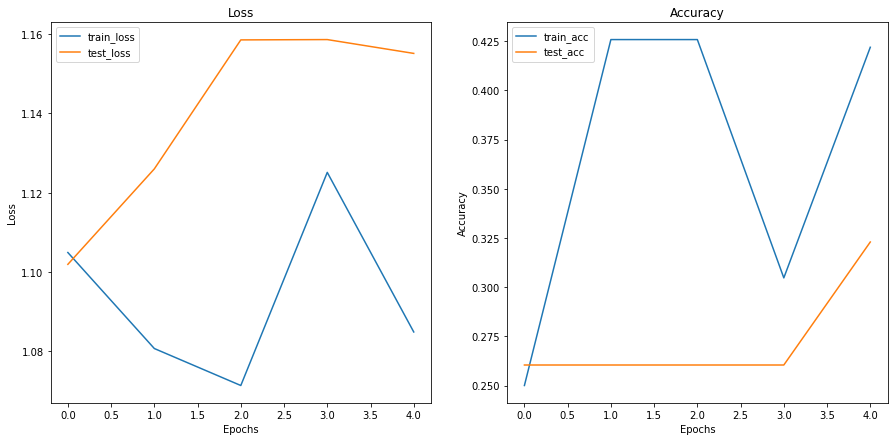

In [69]:
plot_loss_curves(model_1_results)

## 9.5 9.3 Parte dois. Tentando melhorar ainda mais o modelo

Dessa vez, iremos aumentar o número de épocas, o learning rate e a quantidade de neurônios nas camadas ocultas além de alterar o otimizador para o SGD para ver se isso melhora a performance do modelo.

In [72]:
torch.manual_seed(42)
model_1_2 = TinyVGG(input_shape=3,
                  hidden_units=15,
                  output_shape=len(train_data_augmented.classes)).to(device)
model_1_2

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 15, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2535, out_features=3, bias=True)
  )
)

In [73]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 20

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1_2.parameters(),
                             lr=0.01)

from timeit import default_timer as timer
start_time = timer()
model_1_2_results = train(model=model_1_2,
      train_dataloader=train_dataloader_augmented,
      test_dataloader=test_dataloader_simple,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=NUM_EPOCHS,
      device=device)

end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.0985, Train acc: 0.3555 | Test loss: 1.1080, Test_acc: 0.2604
Epoch: 1 | Train loss: 1.0929, Train acc: 0.4258 | Test loss: 1.1157, Test_acc: 0.2604
Epoch: 2 | Train loss: 1.0885, Train acc: 0.4258 | Test loss: 1.1232, Test_acc: 0.2604
Epoch: 3 | Train loss: 1.1072, Train acc: 0.3047 | Test loss: 1.1283, Test_acc: 0.2604
Epoch: 4 | Train loss: 1.0890, Train acc: 0.4258 | Test loss: 1.1331, Test_acc: 0.2604
Epoch: 5 | Train loss: 1.1039, Train acc: 0.3047 | Test loss: 1.1366, Test_acc: 0.2604
Epoch: 6 | Train loss: 1.0979, Train acc: 0.3047 | Test loss: 1.1414, Test_acc: 0.2188
Epoch: 7 | Train loss: 1.0931, Train acc: 0.4141 | Test loss: 1.1431, Test_acc: 0.2604
Epoch: 8 | Train loss: 1.1153, Train acc: 0.3047 | Test loss: 1.1177, Test_acc: 0.2604
Epoch: 9 | Train loss: 1.0918, Train acc: 0.4258 | Test loss: 1.1231, Test_acc: 0.2604
Epoch: 10 | Train loss: 1.0880, Train acc: 0.4258 | Test loss: 1.1283, Test_acc: 0.2604
Epoch: 11 | Train loss: 1.1112, Train acc:

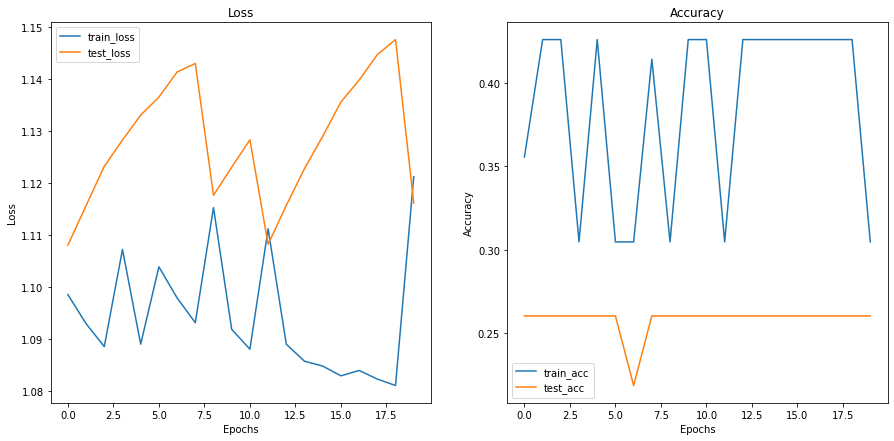

In [74]:
plot_loss_curves(model_1_2_results)

O modelo não larga o osso e continua empacado. Vamos continuar

# 10. Comparando os resultados dos modelo

Depois de avaliar os experimentos dos modelos sozinhos, é importante compará-los uns com os outros.

Existem algumas formas de fazer isso:
1. Escrever código do zero (o que faremos)
2. PyTorch + Tensorboard - https://pytorch.org/docs/stable/tensorboard.html
3. Weights & Biases - https://wandb.ai/site/experiment-tracking
4. mlflow - https://mlflow.org/



In [75]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_1_2_df = pd.DataFrame(model_1_2_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106342,0.304688,1.098314,0.311553
1,1.099485,0.332031,1.069851,0.541667
2,1.086287,0.492188,1.080024,0.522727
3,1.082628,0.410156,1.059862,0.572917
4,1.063007,0.414062,1.060943,0.553977


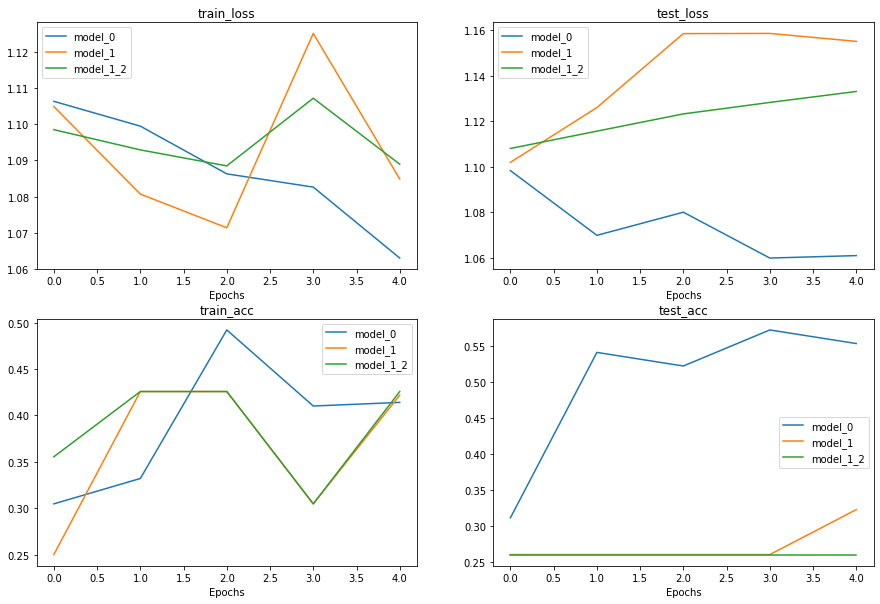

In [99]:
def find_min_epochs(models_results: List[pd.DataFrame]):

  models_epochs = [len(stats['train_loss']) for model, stats in models_results.items()]
  return min(models_epochs)

def plot_models_results(models_results: List[pd.DataFrame]):

  epochs = find_min_epochs(models_results)
  epochs_range = range(epochs)

  NUM_PLOTS = 4
  plot_att_dict = {0: 'train_loss', 1: 'test_loss',
                   2: 'train_acc', 3: 'test_acc'}

  plt.figure(figsize=(15, 10))
  
  for plot_idx in range(NUM_PLOTS):
    plt.subplot(2, 2, plot_idx+1)
    curr_att = plot_att_dict[plot_idx]

    for model_name, model_stats in models_results.items():
      plt.plot(epochs_range, model_stats[curr_att][:epochs], label=model_name)
    
    plt.title(curr_att)
    plt.xlabel("Epochs")
    plt.legend()

all_models_results = {"model_0": model_0_df,
                      "model_1": model_1_df,
                      "model_1_2": model_1_2_df}
plot_models_results(all_models_results)

# 11. Predizendo em uma imagem personalizada

Apesar de termos treinado em dados personalizados, como realizar uma predição em uma imagem que não está no conjunto de treino e nem de teste?


In [132]:
# Download imagem
import requests

custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download se ela ainda não existir
if not custom_image_path.is_file():
  with open(custom_image_path, 'wb') as f:
    raw_link = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg"
    # raw_link = "https://raw.githubusercontent.com/Pendulun/PyTorchStudies/main/PyTorchFreeCodeCampYoutube/aulas/pessoa_com_pizza.jpeg" 
    request = requests.get(raw_link)
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} já existe...")

## 11.1 Carregando a imagem com PyTorch

Temos que garantir que a imagem esteja no mesmo formato no qual o modelo foi treinado:

* Em formato tensor com datatype (torch.float32)
* De shape 64x64x3
* No device certo

Podemos ler uma imagem com PyTorch usando https://pytorch.org/vision/main/generated/torchvision.io.read_image.html

In [133]:
import torchvision

custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f"Custom image tensor:\n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image dtyp

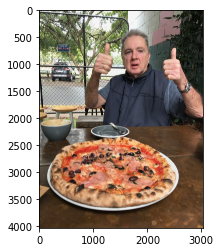

In [134]:
plt.imshow(custom_image_uint8.permute(1, 2, 0))

## 11.2 Realizando uma predição na imagem personalizada com um modelo

In [135]:
# Tentando realizar a predição na imagem original
model_1.eval()
with torch.inference_mode():
  model_1(custom_image_uint8.to(device))

RuntimeError: ignored

In [139]:
# Carregando a imagem e convertendo para torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

In [137]:
model_1.eval()
with torch.inference_mode():
  model_1(custom_image.to(device))

RuntimeError: ignored

In [138]:
custom_image.shape

torch.Size([3, 4032, 3024])

In [143]:
# Criando um pipeline de transform para alterar a imagem
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64))
])

custom_image_transformed = custom_image_transform(custom_image)

print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
Transformed shape: torch.Size([3, 64, 64])


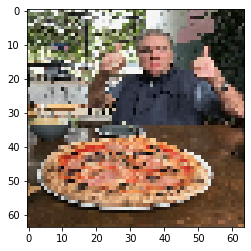

In [146]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [149]:
# Isso vai dar erro pois não tem uma dimensão para o batch size
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.to(device))

RuntimeError: ignored

In [150]:
custom_image_transformed.unsqueeze(0).shape

torch.Size([1, 3, 64, 64])

In [153]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))

custom_image_pred

tensor([[ 0.0707,  0.0494, -0.2073]], device='cuda:0')

Então, nós tivemos que:
* Carregar a imagem e torná-la em um tensor
* Garantir o mesmo dtype (torch.float32)
* Garantir que a imagem tivesse o mesmo shape (3x64x64) com uma dimensão de batch (1, 3, 64, 64) 
* Garantir que a imagem estivesse no mesmo device do modelo

In [154]:
# Convertendo logits -> probabilidades
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3655, 0.3578, 0.2768]], device='cuda:0')

In [159]:
# Convertendo probabilidades -> labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1).cpu()
custom_image_pred_label

tensor([0])

In [160]:
class_names[custom_image_pred_label.item()]

'pizza'

## 11.3 Colocando tudo junto em uma função

Uma função onde passamos um caminho de imagem, o modelo prediz qual a sua classe e, então, plotamos a imagem e a sua classe predita

In [165]:
from IPython.lib.clipboard import tkinter_clipboard_get
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device=device):
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
  target_image /= 255

  if transform:
    target_image = transform(target_image)
  
  model.to(device)
  
  model.eval()
  with torch.inference_mode():
    target_image = target_image.unsqueeze(dim=0).to(device)

    target_image_pred = model(target_image)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1).cpu()

    plt.imshow(target_image.squeeze(0).permute(1, 2, 0).cpu())

    title = ""
    if class_names:
      title = f"Pred: {class_names[target_image_pred_label]}"
    else:
      title = f"Pred: {target_image_pred_label}"
    
    title += f" | Prob: {target_image_pred_probs.max().cpu():.3f}"
    
    plt.title(title)
    plt.axis(False)

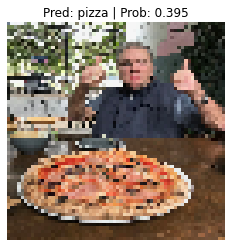

In [168]:
pred_and_plot_image(
    model=model_1_2,
    image_path=custom_image_path,
    class_names=class_names,
    transform=custom_image_transform,
    device=device
)